In [ ]:
# Ch17-2 ScanPy

In [ ]:
# Install Tools #
! pip install scanpy igraph leidenalg

In [ ]:
# Import Libraries #
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
# Optional: Suppress common single-cell analysis warnings for cleaner output
warnings.filterwarnings('ignore', category=RuntimeWarning, message='overflow encountered in expm1')
warnings.filterwarnings('ignore', category=UserWarning, message='Received a view of an AnnData')
warnings.filterwarnings('ignore', category=UserWarning, message='zero-centering a sparse array')

In [ ]:
# Configure scanpy settings
sc.settings.verbosity = 3  # verbosity level

# Configure matplotlib directly instead of using sc.settings.set_figure_params
import matplotlib
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300  # for high-quality saved figures

In [ ]:
# 1. LOAD DATA
# Load the built-in PBMC3k dataset from scanpy
print("Loading PBMC3k dataset...")
adata = sc.datasets.pbmc3k()

In [ ]:
# Alternative: Load preprocessed version (if you want to skip filtering steps)
# adata = sc.datasets.pbmc3k_processed()

# Alternative: Loading from 10X Genomics format files
# adata = sc.read_10x_mtx(
#     'data/',  # Path to the directory containing matrix.mtx, features.tsv, barcodes.tsv
#     var_names='gene_symbols',
#     cache=True
# )

In [ ]:
# Check and handle duplicate names (usually not needed for PBMC3k dataset)
print(f"Variable names unique: {adata.var_names.is_unique}")
print(f"Observation names unique: {adata.obs_names.is_unique}")

# The PBMC3k dataset usually has unique names already, but if not:
if not adata.var_names.is_unique:
    print("Warning: Duplicate gene names found. Consider manual inspection.")
if not adata.obs_names.is_unique:
    print("Warning: Duplicate cell names found. Consider manual inspection.")

In [ ]:
# 2. INITIAL DATA EXPLORATION
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Data shape: {adata.shape}")

In [ ]:
# 3. QUALITY CONTROL METRICS
# Calculate QC metrics
# Mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
# Ribosomal genes  
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL'))
# Hemoglobin genes
adata.var['hb'] = adata.var_names.str.contains('^HB[^(P)]')

# Calculate QC metrics for each cell
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Add mitochondrial gene percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
# 4. VISUALIZE QC METRICS
# Let scanpy handle the plotting layout automatically
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Scatter plots to identify outliers
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# 5. FILTER CELLS AND GENES
print(f"Before filtering: {adata.n_obs} cells, {adata.n_vars} genes")

# Filter cells with too few or too many genes
sc.pp.filter_cells(adata, min_genes=200)  # filter out cells with < 200 genes
sc.pp.filter_genes(adata, min_cells=3)    # filter out genes expressed in < 3 cells

# Filter cells with high mitochondrial gene percentage (dying cells)
adata = adata[adata.obs.pct_counts_mt < 20, :]

# Filter cells with too many total counts (potential doublets)
adata = adata[adata.obs.total_counts < 30000, :]

# Filter cells with too few total counts
adata = adata[adata.obs.total_counts > 1000, :]

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")

In [ ]:
# 6. SAVE RAW DATA
# Save the raw data before normalization
adata.raw = adata

# Check basic statistics of the raw data
print("Raw data statistics:")
if hasattr(adata.X, 'data'):  # sparse matrix
    print(f"Raw data range: {adata.X.data.min():.2f} to {adata.X.data.max():.2f}")
    print(f"Raw data mean: {adata.X.data.mean():.2f}")
    print(f"Number of zeros: {(adata.X.data == 0).sum()}")
else:  # dense matrix
    print(f"Raw data range: {adata.X.min():.2f} to {adata.X.max():.2f}")
    print(f"Raw data mean: {adata.X.mean():.2f}")
    print(f"Number of zeros: {(adata.X == 0).sum()}")

In [ ]:
# 7. FIND HIGHLY VARIABLE GENES
# First, let's check for problematic values in the data
print("Checking for infinite or NaN values...")
print(f"Contains infinite values: {np.isinf(adata.X.data).any() if hasattr(adata.X, 'data') else np.isinf(adata.X).any()}")
print(f"Contains NaN values: {np.isnan(adata.X.data).any() if hasattr(adata.X, 'data') else np.isnan(adata.X).any()}")

# Clean the data if needed
if hasattr(adata.X, 'data'):  # sparse matrix
    # Replace infinite values with zero
    inf_mask = np.isinf(adata.X.data)
    if inf_mask.any():
        print("Replacing infinite values with zero...")
        adata.X.data[inf_mask] = 0
    
    # Replace NaN values with zero
    nan_mask = np.isnan(adata.X.data)
    if nan_mask.any():
        print("Replacing NaN values with zero...")
        adata.X.data[nan_mask] = 0
else:  # dense matrix
    adata.X[np.isinf(adata.X)] = 0
    adata.X[np.isnan(adata.X)] = 0

# Try different approaches for highly variable genes
try:
    # Use n_top_genes without conflicting parameters
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
    print(f"Selected {adata.var['highly_variable'].sum()} highly variable genes using Seurat method")
        
except (ValueError, RuntimeError) as e:
    print(f"Standard highly variable genes failed: {e}")
    print("Trying alternative approach...")
    
    # Alternative: use Seurat method which is more robust
    try:
        sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
        print(f"Selected {adata.var['highly_variable'].sum()} highly variable genes")
    except Exception as e2:
        print(f"Seurat method also failed: {e2}")
        print("Using simple variance-based selection...")
        
        # Manual selection based on variance
        if hasattr(adata.X, 'toarray'):
            X_dense = adata.X.toarray()
        else:
            X_dense = adata.X
        
        # Calculate variance for each gene
        gene_var = np.var(X_dense, axis=0)
        # Select top 2000 most variable genes
        top_var_indices = np.argsort(gene_var)[-2000:]
        adata.var['highly_variable'] = False
        adata.var.iloc[top_var_indices, adata.var.columns.get_loc('highly_variable')] = True
        
        print(f"Selected {adata.var['highly_variable'].sum()} highly variable genes")

# Keep only highly variable genes for downstream analysis
adata = adata[:, adata.var.highly_variable]

In [ ]:
# 8. NORMALIZATION AND SCALING
# Normalize to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform (add pseudocount to avoid log(0))
sc.pp.log1p(adata)

# IMPORTANT: Save log-normalized data for later differential expression analysis
adata.layers['log1p'] = adata.X.copy()

# Check for problematic values after log transformation
print("After log transformation:")
if hasattr(adata.X, 'data'):
    print(f"Max value: {adata.X.data.max()}")
    print(f"Min value: {adata.X.data.min()}")
    print(f"Contains infinite: {np.isinf(adata.X.data).any()}")
else:
    print(f"Max value: {adata.X.max()}")
    print(f"Min value: {adata.X.min()}")
    print(f"Contains infinite: {np.isinf(adata.X).any()}")

# Scale data (zero mean, unit variance) - be more conservative
sc.pp.scale(adata, max_value=10)a

In [ ]:
# 9. PRINCIPAL COMPONENT ANALYSIS
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [ ]:
# 10. COMPUTE NEIGHBORHOOD GRAPH
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# 11. PERFORM UMAP EMBEDDING
sc.tl.umap(adata)

In [ ]:
# 12. CLUSTERING
# Leiden clustering
sc.tl.leiden(adata, resolution=0.5)

# Alternative: Louvain clustering
# sc.tl.louvain(adata, resolution=0.5)

In [ ]:
# 13. VISUALIZATION
# Plot UMAP with clusters
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', 
           title='Leiden Clustering', frameon=False, save='.pdf')

# Plot QC metrics on UMAP
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
           ncols=3)

In [ ]:
# 14. FIND MARKER GENES
# Find marker genes for each cluster using log-transformed (but unscaled) data
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False, layer='log1p')

# Plot top marker genes
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

# Get marker gene results as DataFrame
result = sc.get.rank_genes_groups_df(adata, group='0')  # for cluster 0
print(result.head(10))

In [ ]:
# 15. PLOT SPECIFIC GENES
# PBMC-specific marker genes (these should be present in the PBMC3k dataset)
marker_genes = ['CD3D', 'CD3E', 'CD8A', 'CD4', 'IL7R',  # T cells
                'CD14', 'LYZ', 'FCGR3A',                 # Monocytes  
                'MS4A1', 'CD79A',                        # B cells
                'GNLY', 'NKG7',                          # NK cells
                'FCER1A', 'CST3']                        # Dendritic cells

# Check which genes are available in the dataset
available_genes = [gene for gene in marker_genes if gene in adata.raw.var_names]
print(f"Available marker genes: {available_genes}")

if available_genes:
    # Use raw data for plotting to show actual expression levels
    sc.pl.umap(adata, color=available_genes, use_raw=True, ncols=3)


In [ ]:
# 16. SAVE RESULTS
# Create results directory if it doesn't exist
import os
os.makedirs('results', exist_ok=True)

# Save the analysis results
adata.write('results/pbmc3k_analyzed.h5ad')

# Export cluster information
cluster_df = pd.DataFrame({
    'cell_barcode': adata.obs.index,
    'cluster': adata.obs['leiden'],
    'n_genes': adata.obs['n_genes_by_counts'],
    'total_counts': adata.obs['total_counts'],
    'mt_percent': adata.obs['pct_counts_mt']
})
cluster_df.to_csv('results/pbmc3k_cluster_assignments.csv', index=False)

# Export marker genes for all clusters
marker_genes_df = sc.get.rank_genes_groups_df(adata, group=None)
marker_genes_df.to_csv('results/pbmc3k_marker_genes.csv', index=False)

print("Analysis complete! Results saved to 'results/' directory.")

Loading PBMC3k dataset...
Variable names unique: True
Observation names unique: True
Number of cells: 2700
Number of genes: 32738
Data shape: (2700, 32738)


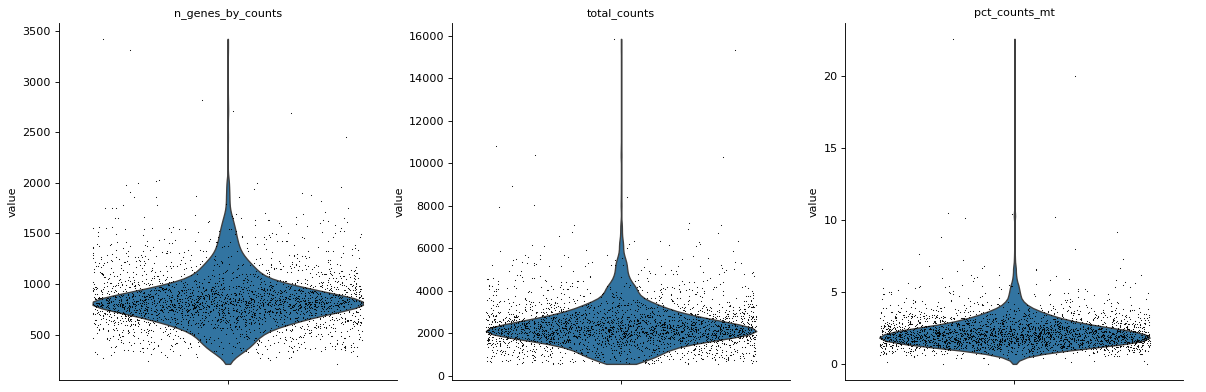

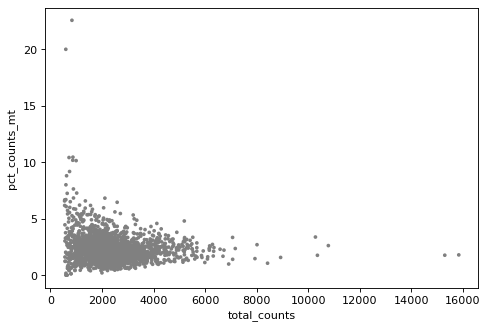

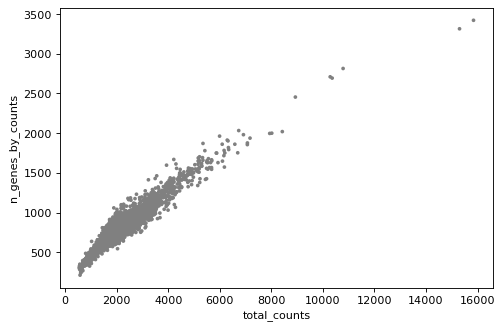

Before filtering: 2700 cells, 32738 genes
After filtering: 2547 cells, 13714 genes
Raw data statistics:
Raw data range: 1.00 to 419.00
Raw data mean: 2.82
Number of zeros: 0
Checking for infinite or NaN values...
Contains infinite values: False
Contains NaN values: False
Standard highly variable genes failed: cannot specify integer `bins` when input data contains infinity
Trying alternative approach...
Seurat method also failed: cannot specify integer `bins` when input data contains infinity
Using simple variance-based selection...
Selected 2000 highly variable genes
After log transformation:
Max value: 7.4453444480896
Min value: 0.5848858952522278
Contains infinite: False


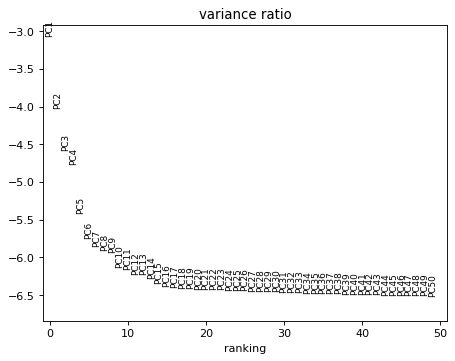

saving figure to file figures/umap.pdf


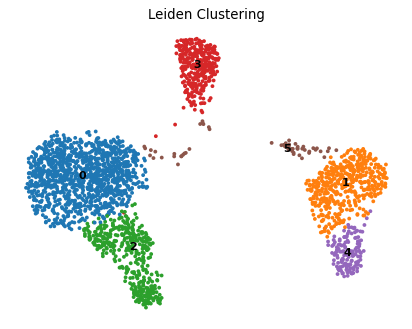

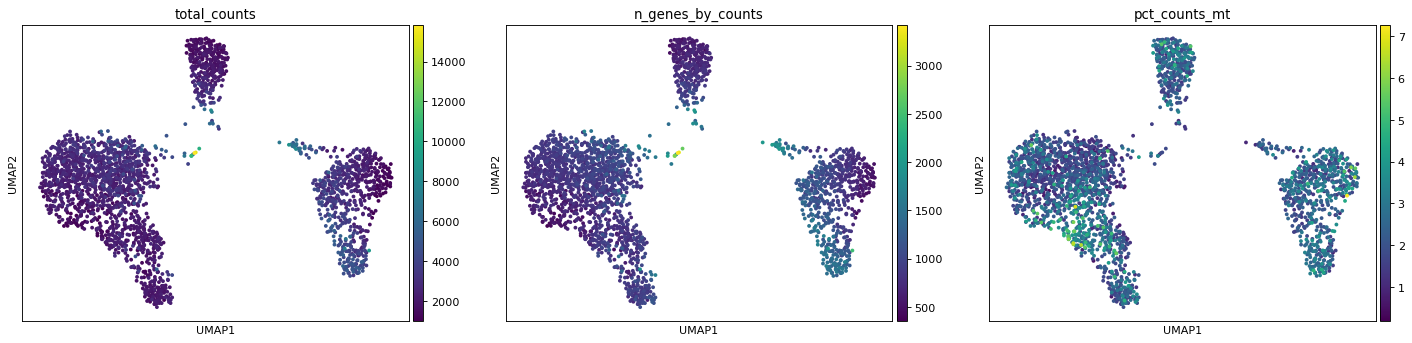

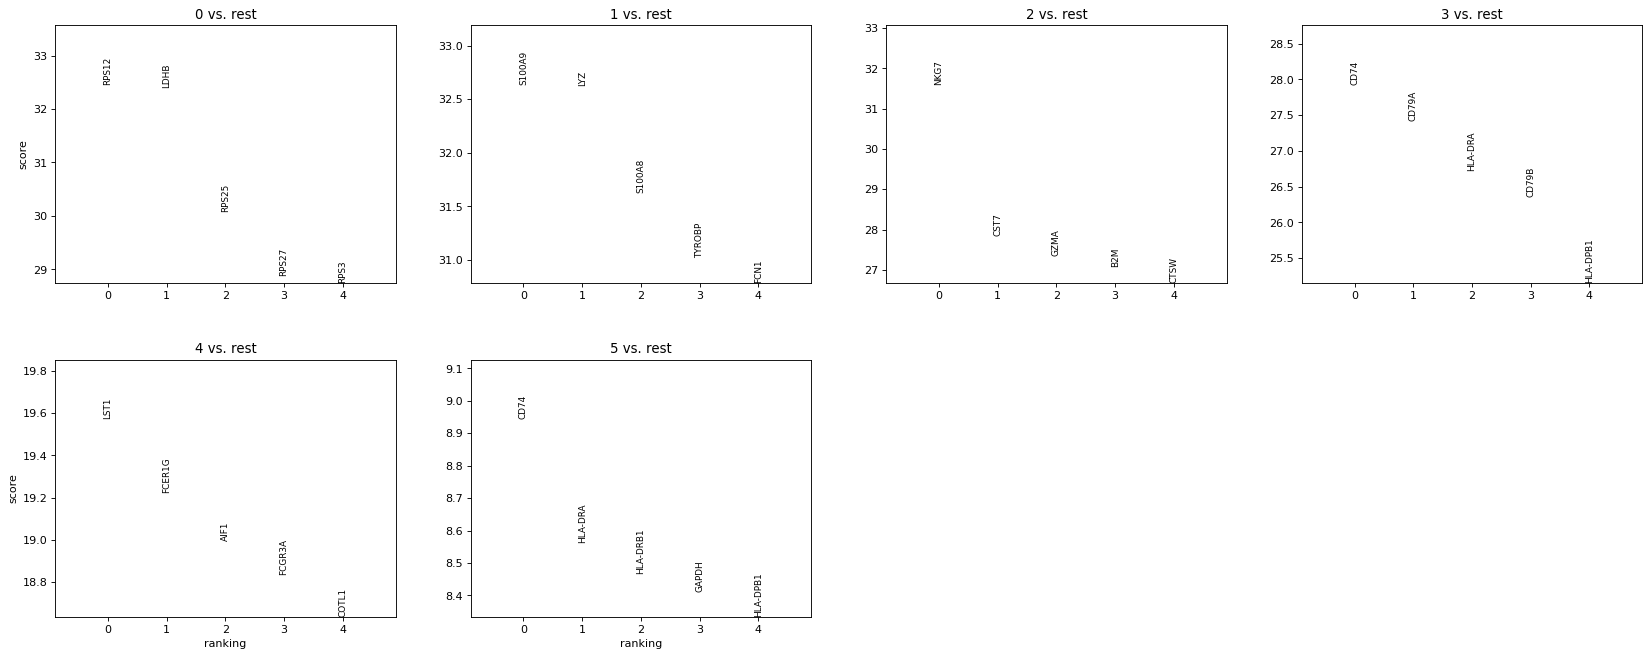

   names     scores  logfoldchanges          pvals      pvals_adj
0  RPS12  32.454102        0.981995  4.740760e-231  9.481519e-228
1   LDHB  32.392857        2.779047  3.460009e-230  2.306673e-227
2  RPS25  30.076101        1.137489  9.953146e-199  3.981258e-196
3  RPS27  28.885422        0.968121  1.820167e-183  4.550418e-181
4   RPS3  28.752247        0.817518  8.490169e-182  1.886704e-179
5   RPS6  28.437962        0.796222  6.865949e-178  1.248354e-175
6  RPS14  27.966991        0.726878  4.096851e-172  6.302847e-170
7   CD3D  27.639046        3.286495  3.779390e-168  5.399129e-166
8  RPL31  27.256237        1.061678  1.401748e-163  1.868997e-161
9   RPL3  26.922096        0.813538  1.210831e-159  1.513539e-157
Available marker genes: ['CD3D', 'CD3E', 'CD8A', 'CD4', 'IL7R', 'CD14', 'LYZ', 'FCGR3A', 'MS4A1', 'CD79A', 'GNLY', 'NKG7', 'FCER1A', 'CST3']


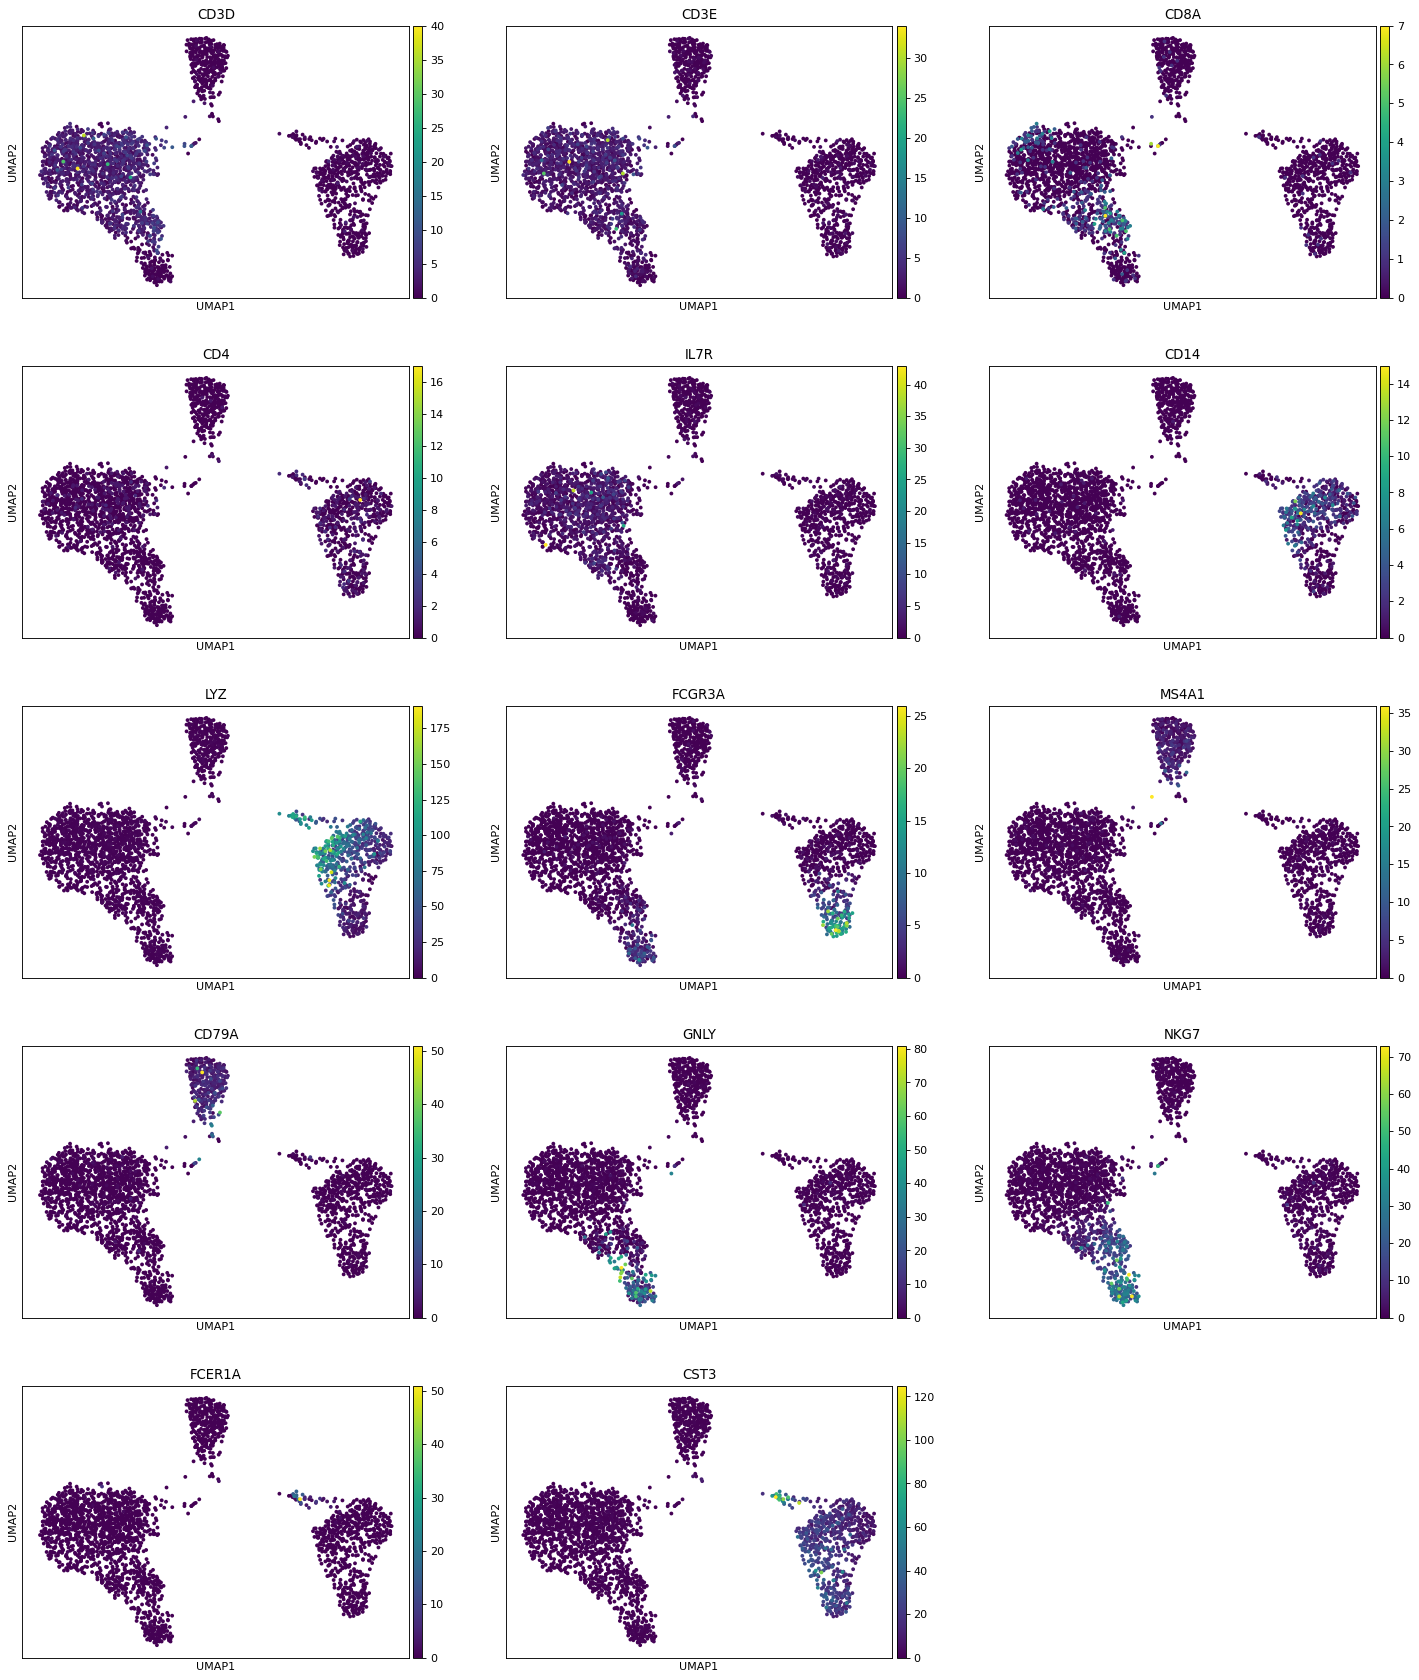

Analysis complete! Results saved to 'results/' directory.
Found clusters: ['0', '1', '2', '3', '4', '5']
Existing clusters: ['0', '3', '1', '2', '4', '5']
Cell type counts:
cell_type
CD4+ T cells         1160
CD14+ Monocytes       457
B cells               411
CD8+ T cells          316
FCGR3A+ Monocytes     146
NK cells               57
Name: count, dtype: int64


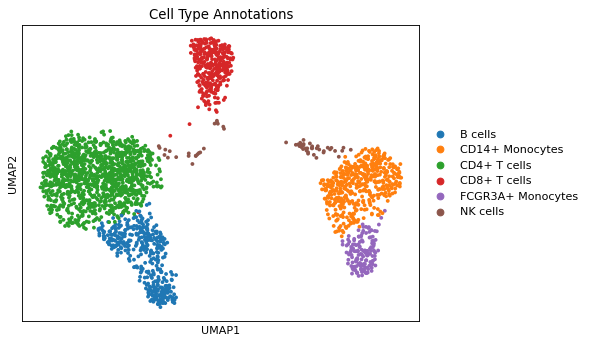


Final dataset info:
Cells: 2547
Genes: 2000
Clusters found: 6
Cell types annotated: cell_type
CD4+ T cells         1160
CD14+ Monocytes       457
B cells               411
CD8+ T cells          316
FCGR3A+ Monocytes     146
NK cells               57
Name: count, dtype: int64


In [17]:
# 17. OPTIONAL: CELL TYPE ANNOTATION
# This would typically involve comparing marker genes to known cell type signatures
# For PBMC data, we expect to see major immune cell types

# First, let's see what clusters we actually have
print(f"Found clusters: {sorted(adata.obs['leiden'].unique())}")

# Example of manual annotation based on marker genes (adjust based on your results):
# You would determine these mappings by examining the marker genes for each cluster
cluster_annotations = {
    '0': 'CD4+ T cells',
    '1': 'CD14+ Monocytes', 
    '2': 'B cells',
    '3': 'CD8+ T cells',
    '4': 'FCGR3A+ Monocytes',
    '5': 'NK cells',
    '6': 'Dendritic cells',
    '7': 'Megakaryocytes',
    # Add more based on your marker gene analysis
    # The exact mapping will depend on your clustering resolution and results
}

# Add annotations to the data (handle categorical properly)
existing_clusters = adata.obs['leiden'].unique()
print(f"Existing clusters: {list(existing_clusters)}")

# Convert leiden to string to avoid categorical issues
leiden_str = adata.obs['leiden'].astype(str)

# Create cell type annotations
cell_types = []
for cluster in leiden_str:
    if cluster in cluster_annotations:
        cell_types.append(cluster_annotations[cluster])
    else:
        cell_types.append('Unknown')

# Add to adata
adata.obs['cell_type'] = cell_types

# Convert to categorical for memory efficiency (optional)
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')

print(f"Cell type counts:")
print(adata.obs['cell_type'].value_counts())

# Plot with cell type annotations
sc.pl.umap(adata, color='cell_type', title='Cell Type Annotations')

print("\nFinal dataset info:")
print(f"Cells: {adata.n_obs}")
print(f"Genes: {adata.n_vars}")
print(f"Clusters found: {len(adata.obs['leiden'].unique())}")
print(f"Cell types annotated: {adata.obs['cell_type'].value_counts()}")

In [ ]:
## End of Notebook ##